# Lifecycle Model - Initial Regression Attempt

⚠️ **Note:** This was our first approach using regression to predict exact trending days. 
We achieved R² = 0.95 but discovered data leakage. After fixing, regression failed 
(R² went negative), leading us to pivot to classification in `model_training.ipynb`.

This notebook is kept for transparency and documentation of our iterative process.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Loading Data Set


In [34]:
df = pd.read_csv("../data_processed/subset_newest_10k.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   video_id                         10000 non-null  object 
 1   video_published_at               10000 non-null  object 
 2   video_trending__date             10000 non-null  object 
 3   video_trending_country           10000 non-null  object 
 4   channel_id                       10000 non-null  object 
 5   video_title                      10000 non-null  object 
 6   video_description                9822 non-null   object 
 7   video_default_thumbnail          10000 non-null  object 
 8   video_category_id                10000 non-null  object 
 9   video_tags                       7832 non-null   object 
 10  video_duration                   10000 non-null  object 
 11  video_dimension                  10000 non-null  object 
 12  video_definition   

In [35]:
df.head()

,video_id,video_published_at,video_trending__date,video_trending_country,channel_id,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,...,channel_description,channel_custom_url,channel_published_at,channel_country,channel_view_count,channel_subscriber_count,channel_have_hidden_subscribers,channel_video_count,channel_localized_title,channel_localized_description
0,dBBW7hKF9WI,2025-09-28T12:15:49Z,2025.09.29,United States,UCxfr3b8IuHSzu22UHnAvHWg,Finally Had Deep Runs in Megabonk,Starting to cook,https://i.ytimg.com/vi/dBBW7hKF9WI/default.jpg,Gaming,NaN,...,This channel is proof I am the ultimate variet...,@moistcr1tikalgamingofficial,2025-06-10T20:16:40.652453Z,United States,3.123504e+07,522000.0,False,169.0,MoistCr1TiKaL Gaming,This channel is proof I am the ultimate variet...
1,U-124RmcV7I,2025-09-30T00:30:08Z,2025.09.30,United States,UCpTaAz_BxtkUB1qc8JTU_7g,Doja Cat - Stranger (Official Video),"Doja Cat’s new album, ‘Vie’ out now: https://d...",https://i.ytimg.com/vi/U-124RmcV7I/default.jpg,Music,"Doja Cat Stranger,Vie,Doja Cat Vie,Doja Cat ne...",...,Follow Doja Cat :\nhttps://www.facebook.com/Do...,@dojacatvevo,2014-03-03T20:35:28Z,NaN,6.620018e+09,260000.0,False,146.0,dojacatVEVO,Follow Doja Cat :\nhttps://www.facebook.com/Do...
2,i-8w5yDwukA,2025-09-29T12:30:27Z,2025.09.30,United States,UCrzx3ZPXEZpzEGLF1gIuORQ,The Raja Saab Telugu Trailer | Prabhas | Marut...,Enter the world of The RajaSaab. Biggest Horro...,https://i.ytimg.com/vi/i-8w5yDwukA/default.jpg,Entertainment,"People Media Factory,Raja Saab,Raja Saab Trail...",...,Welcome to the official channel of People Medi...,@peoplemediafactory,2016-09-21T08:52:06Z,India,9.062376e+08,1250000.0,False,2593.0,People Media Factory,Welcome to the official channel of People Medi...
3,TVTMZYU67dA,2025-09-29T19:00:23Z,2025.09.30,United States,UCp1VWSTrt2cUBInkn4dUmDA,"DONE WITH DECISION BASED GAMES - No, I'm Not A...",Official #EEZYGANG MERCH!! - https://www.eezyg...,https://i.ytimg.com/vi/TVTMZYU67dA/default.jpg,Gaming,"Berleezy,iBerleezy,Gameplay,Walkthrough,Lets P...",...,Handsome unc.\n\n#eezygang MERCH!! - https://...,@berleezy,2016-06-14T08:10:22Z,United States,9.041549e+08,2810000.0,False,1157.0,berleezy,Handsome unc.\n\n#eezygang MERCH!! - https://...
4,An3OhxlfjAs,2025-09-26T19:20:52Z,2025.09.30,United States,UCEBTD8bc2J7wG7Fqhss7Jow,Broken Halos,Provided to YouTube by Universal Music Group\n...,https://i.ytimg.com/vi/An3OhxlfjAs/default.jpg,Music,"Chris Stapleton,クリスステイプルトン,クリス・ステイプルトン,2018 Aw...",...,"Starting Over, the highly anticipated new stud...",NaN,2013-12-19T00:50:31Z,NaN,1.126463e+09,51700.0,False,112.0,Chris Stapleton - Topic,"Starting Over, the highly anticipated new stud..."


In [36]:
# Check if you have multiple rows for the same video
duplicates = len(df) - len(df['video_id'].unique())

print(f"Total Rows: {len(df)}")
print(f"Unique Videos: {len(df['video_id'].unique())}")
print(f"Duplicate Rows: {duplicates}")

Total Rows: 10000
Unique Videos: 8249
Duplicate Rows: 1751


# Data Cleaning and Feature Engineering 

In [37]:
# Rename for clarity

df = df.rename(columns={
    'video_id': 'video_id',
    'video_published_at': 'published_at',
    'video_trending__date': 'trending_date',
    'video_view_count': 'views',
    'video_like_count': 'likes',
    'video_comment_count': 'comments',
    'video_description': 'description',
    'video_tags': 'tags',
    'video_category_id': 'category',
    'video_duration': 'duration'
})

In [38]:
# Convert Duration to minutes (int)

def iso_to_minutes(duration):
    if not isinstance(duration, str):
        return 0
    duration = duration.replace('PT','')
    h = m = s = 0
    if 'H' in duration:
        parts = duration.split('H')
        h = int(parts[0])
        duration = parts[1] if len(parts) > 1 else ''
    if 'M' in duration:
        parts = duration.split('M')
        m = int(parts[0])
        duration = parts[1] if len(parts) > 1 else ''
    if 'S' in duration:
        s = int(duration.replace('S',''))
    return h*60 + m + s/60

df['duration'] = df['duration'].apply(iso_to_minutes)

In [39]:
# Feature Engineer Time-Based Columns
df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')
df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce', utc=True)
df['published_at'] = df['published_at'].dt.tz_localize(None)

today = pd.Timestamp.today().tz_localize(None)

df['days_since_pub'] = (today - df['published_at']).dt.days

df['publish_year'] = df['published_at'].dt.year
df['publish_month'] = df['published_at'].dt.month
df['publish_dayofweek'] = df['published_at'].dt.dayofweek
df['publish_hour'] = df['published_at'].dt.hour
df['is_weekend'] = df['publish_dayofweek'].isin([5,6]).astype(int)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   video_id                         10000 non-null  object        
 1   published_at                     10000 non-null  datetime64[ns]
 2   trending_date                    10000 non-null  datetime64[ns]
 3   video_trending_country           10000 non-null  object        
 4   channel_id                       10000 non-null  object        
 5   video_title                      10000 non-null  object        
 6   description                      9822 non-null   object        
 7   video_default_thumbnail          10000 non-null  object        
 8   category                         10000 non-null  object        
 9   tags                             7832 non-null   object        
 10  duration                         10000 non-null  float64   

In [41]:
# Feature Engineer Engagement-Based Metrics

df['engagement_ratio'] = (df['likes'] + df['comments']) / df['views']
df['likes_ratio'] = df['likes'] / df['views']
df['comments_ratio'] = df['comments'] / df['views']


In [42]:
# Feature Engineer word-based metrics

df['description_word_count'] = df['description'].fillna("").str.split().str.len()
df['title_word_count'] = df['video_title'].fillna("").str.split().str.len()

df['description_char_count'] = df['description'].fillna("").str.len()
df['title_char_count'] = df['video_title'].fillna("").str.len()

df['tags_count'] = df['tags'].fillna("").str.split(',').str.len()

In [43]:
# Feature Engineer lifespan features

# Days Trending
days_trending = df.groupby('video_id').size().rename('total_days_trending')
df = df.merge(days_trending, on='video_id', how='left')

In [44]:
# How long did it take for the video to become trending?

df['days_until_trending'] = (
    df['trending_date'].dt.date - df['published_at'].dt.date
    ).apply(lambda x: x.days)



In [45]:
df.groupby('video_id').count().sort_values(by = 'trending_date', ascending = False)

,published_at,trending_date,video_trending_country,channel_id,video_title,description,video_default_thumbnail,category,tags,duration,...,engagement_ratio,likes_ratio,comments_ratio,description_word_count,title_word_count,description_char_count,title_char_count,tags_count,total_days_trending,days_until_trending
video_id,,,,,,,,,,,,,,,,,,,,,
xapibmVTQOU,22,22,22,22,22,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22
5nzS_gV2stw,17,17,17,17,17,17,17,17,17,17,...,17,17,17,17,17,17,17,17,17,17
yel9ghHqoKo,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
l0OQhp3-qd0,15,15,15,15,15,15,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
uh7AaPMv5yM,14,14,14,14,14,14,14,14,14,14,...,14,14,14,14,14,14,14,14,14,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LhEgYusyOsk,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Lh1Wt8adGlQ,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
LgeVk6-Wrns,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [46]:
# Feature Engineer Lifespan Features

# First trend date, last trend date
trend_span = df.groupby('video_id')['trending_date'].agg(['min', 'max']).reset_index()
trend_span.columns = ['video_id', 'first_trend_date', 'last_trend_date']

In [47]:
df = df.merge(trend_span, on='video_id', how='left')

In [48]:
df.columns

Index(['video_id', 'published_at', 'trending_date', 'video_trending_country',
       'channel_id', 'video_title', 'description', 'video_default_thumbnail',
       'category', 'tags', 'duration', 'video_dimension', 'video_definition',
       'video_licensed_content', 'views', 'likes', 'comments', 'channel_title',
       'channel_description', 'channel_custom_url', 'channel_published_at',
       'channel_country', 'channel_view_count', 'channel_subscriber_count',
       'channel_have_hidden_subscribers', 'channel_video_count',
       'channel_localized_title', 'channel_localized_description',
       'days_since_pub', 'publish_year', 'publish_month', 'publish_dayofweek',
       'publish_hour', 'is_weekend', 'engagement_ratio', 'likes_ratio',
       'comments_ratio', 'description_word_count', 'title_word_count',
       'description_char_count', 'title_char_count', 'tags_count',
       'total_days_trending', 'days_until_trending', 'first_trend_date',
       'last_trend_date'],
      dtype='

# ⚠️ FIXING DATA LEAKAGE  ⚠️

## The following scores are now accurate to the models

Results: Bad Scores all around R^2 <= 0

In [49]:
# Group by Video ID to remove duplicates
# We take 'max' for the target (to get the final total days)
# We take 'first' for the features (since they don't change)
df_clean = df.groupby('video_id', as_index=False).agg({
    'total_days_trending': 'max',      # The Target: Grab the highest number recorded
    'duration': 'first',               # Feature: Video length in seconds
    'description_word_count': 'first', 
    'title_char_count': 'first',       
    'tags_count': 'first',             
    'publish_hour': 'first',           
    'is_weekend': 'first',             
    'category': 'first'                
})

print(f"New Row Count: {len(df_clean)}") 

New Row Count: 8249


# Modeling

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [51]:
# Selected features
features = [
    'duration',
    'description_word_count',
    'title_char_count',
    'tags_count',
    'publish_hour',
    'is_weekend',
    'category',
]

X = df_clean[features]
y = df_clean['total_days_trending']

# One-hot encode the 'category' column
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
category_encoded = encoder.fit_transform(X[['category']])

# Get new column names
category_cols = encoder.get_feature_names_out(['category'])

# Convert to DataFrame and align indices
category_df = pd.DataFrame(category_encoded, columns=category_cols, index=X.index)

# Drop original category column and concatenate encoded columns
X_numeric = X.drop(columns=['category'])
X_final = pd.concat([X_numeric, category_df], axis=1)


# Remove any null values
X_final = X_final.dropna()
y = df.loc[X_final.index, 'total_days_trending']


X_final.head()


,duration,description_word_count,title_char_count,tags_count,publish_hour,is_weekend,category_Comedy,category_Education,category_Entertainment,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Science & Technology,category_Sports,category_Travel & Events
0,40.166667,34,39,9,21,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11.200000,51,48,17,23,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4.133333,77,28,1,18,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,39.033333,55,34,21,16,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.783333,449,38,18,17,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


 # Train Test Split

In [52]:
# 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# Linear Regression

In [53]:
from sklearn.linear_model import LinearRegression

In [54]:
# Initialize Linear Regression
lr = LinearRegression()

# Fit the model
lr.fit(X_train, y_train)

# Predict on test set
y_pred = lr.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression MSE: {mse:.2f}")
print(f"Linear Regression R^2: {r2:.2f}")

Linear Regression MSE: 3.37
Linear Regression R^2: -0.00


# Polynomial Regression

In [55]:
from sklearn.preprocessing import PolynomialFeatures

# chose degree 2 to capture curves without overfitting
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)
poly_predictions = model.predict(X_test_poly)

poly_mae = mean_absolute_error(y_test, poly_predictions)
poly_mse = mean_squared_error(y_test, poly_predictions)

poly_r2 = r2_score(y_test, poly_predictions)

print(f"Polynomial Mean Squared Error (MSE): {poly_mse:.2f}")
print(f"Polynomial R-squared (R²): {poly_r2:.2f}")

Polynomial Mean Squared Error (MSE): 3.44
Polynomial R-squared (R²): -0.03


# Random Forest

In [56]:
from sklearn.ensemble import RandomForestRegressor

# Random Forest
rf_total_days_trending = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
rf_total_days_trending.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_total_days_trending.predict(X_test)

# Evaluation
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.2f}")
print(f"Random Forest R^2: {r2_rf:.2f}")

Random Forest MSE: 3.80
Random Forest R^2: -0.13


                          Feature  Importance
0                        duration    0.323327
1          description_word_count    0.201722
2                title_char_count    0.176209
4                    publish_hour    0.127884
3                      tags_count    0.105520
5                      is_weekend    0.026109
8          category_Entertainment    0.010311
12                 category_Music    0.009096
14        category_People & Blogs    0.007264
10                category_Gaming    0.005966
9       category_Film & Animation    0.003403
16                category_Sports    0.002650
15  category_Science & Technology    0.000291
6                 category_Comedy    0.000226
13       category_News & Politics    0.000010
11         category_Howto & Style    0.000007
7              category_Education    0.000003
17       category_Travel & Events    0.000001


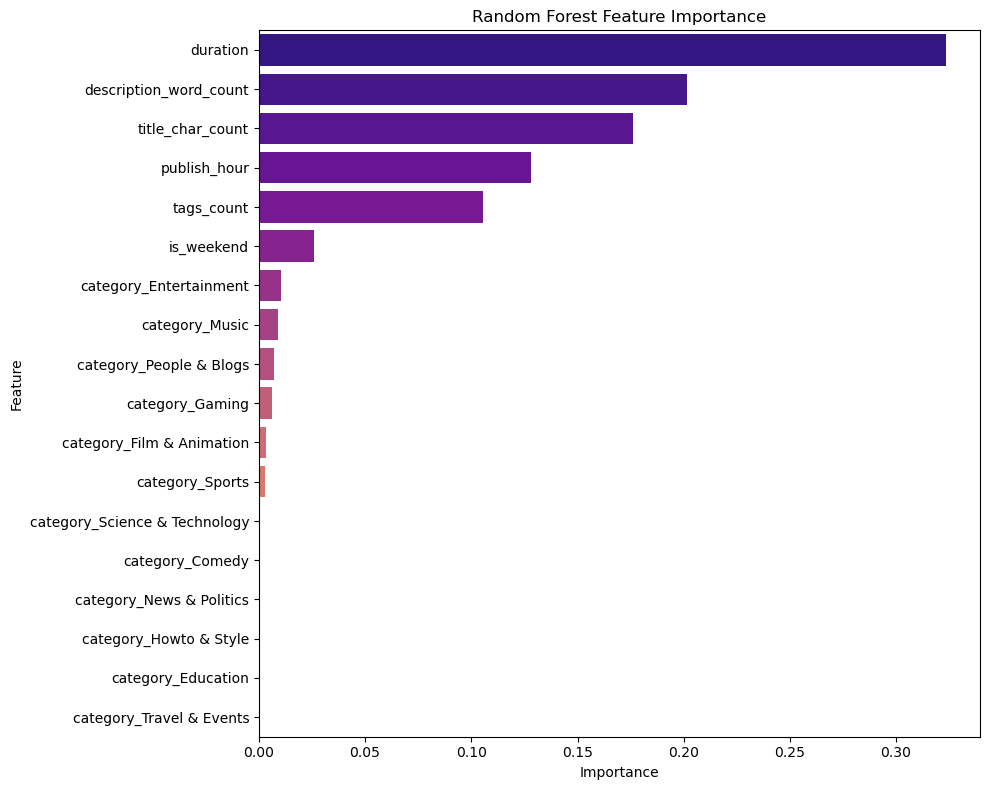

In [57]:
# Feature Importance

features_df = pd.DataFrame({
    'Feature': X_final.columns,
    'Importance': rf_total_days_trending.feature_importances_
})

# Sort by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display
print(features_df)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=features_df, x='Importance', y='Feature', palette='plasma', hue='Feature')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

# XG Boost

In [58]:
import xgboost as xgb
from xgboost import XGBRegressor

In [59]:
xgb = XGBRegressor(objective='reg:squarederror',
                        n_estimators=100, random_state=42)

xgb.fit(X_train, y_train)

xgb_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print(f'XG Boost MSE: {mse:.3f}')
print(f'XG Boost R²: {r2:.3f}')


XG Boost MSE: 4.433
XG Boost R²: -0.322


# Hyper Parameter Tuning (GridSearchCV)

In [60]:
from sklearn.model_selection import GridSearchCV

In [61]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 15,25],
    'min_samples_leaf': [1,2,4],
    'max_features': ['sqrt', 0.5]
}


grid_search = GridSearchCV(
    estimator=rf_total_days_trending,
    param_grid=param_grid,
    cv=5,                 # 5-fold cross-validation
    n_jobs=-1,            # use all CPUs
    scoring= 'neg_root_mean_squared_error',         # optimize for MSE
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   0.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_depth': [None, 15, ...], 'max_features': ['sqrt', 0.5], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [100, 200]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


In [62]:
# Best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)

print("Tuned RF MSE:", mean_squared_error(y_test, y_pred_best))
print("Tuned RF R^2:", r2_score(y_test, y_pred_best))


Best parameters: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 200}
Tuned RF MSE: 3.4389120158249264
Tuned RF R^2: -0.02517248613540013


# Testing on User Inputs


In [63]:
import pandas as pd

# Example input (values must match the features used in training)
# Features: duration, description_word_count, title_word_count, tags_count, publish_hour, is_weekend, category

test_input = pd.DataFrame({
    'duration': [2],               
    'description_word_count': [50],  
    'title_char_count': [45],    # cannot exceed 100 characters     
    'tags_count': [5],               
    'publish_hour': [9],             # 0-23
    'is_weekend': [1],               # 0 or 1
    'category': ['Music']        # Must be listed category
})

# One-hot encode category
category_encoded = encoder.transform(test_input[['category']])
category_cols = encoder.get_feature_names_out(['category'])
category_df = pd.DataFrame(category_encoded, columns=category_cols, index=test_input.index)

# Combine with numeric features
X_test_input = test_input.drop(columns=['category'])
X_test_final = pd.concat([X_test_input, category_df], axis=1)

# Predict
predicted_days = rf_total_days_trending.predict(X_test_final)
print("Predicted days on trending:", predicted_days[0])


X_test_final


Predicted days on trending: 1.72


,duration,description_word_count,title_char_count,tags_count,publish_hour,is_weekend,category_Comedy,category_Education,category_Entertainment,category_Film & Animation,category_Gaming,category_Howto & Style,category_Music,category_News & Politics,category_People & Blogs,category_Science & Technology,category_Sports,category_Travel & Events
0,2,50,45,5,9,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   video_id                         10000 non-null  object        
 1   published_at                     10000 non-null  datetime64[ns]
 2   trending_date                    10000 non-null  datetime64[ns]
 3   video_trending_country           10000 non-null  object        
 4   channel_id                       10000 non-null  object        
 5   video_title                      10000 non-null  object        
 6   description                      9822 non-null   object        
 7   video_default_thumbnail          10000 non-null  object        
 8   category                         10000 non-null  object        
 9   tags                             7832 non-null   object        
 10  duration                         10000 non-null  float64   